In [927]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine, text
import pymc as pm
import arviz as az
from scipy.stats import zscore

# Define the SQLalchemy engine
engine = create_engine(f"sqlite:////Users/JO/PhD/neuro-ascertainment/data/db.sqlite")

# Read the SQL query from the file
with open('/Users/JO/PhD/neuro-ascertainment/candidate-queries/transferred-nsicu-cohort/transferred-cohort.sql', 'r') as file:
    query = file.read()

SEED = 20
rng = np.random.default_rng(SEED)

def count_id(df):
    LopNr = df['LopNr'].nunique() if 'LopNr' in df else 'Column missing'
    VtfId_LopNr = df['VtfId_LopNr'].nunique() if 'VtfId_LopNr' in df else 'Column missing'
    HADM_ID = df['HADM_ID'].nunique() if 'HADM_ID' in df else 'Column missing'
    return print(f'Unique patients: {LopNr} | Unique SIR admits: {VtfId_LopNr} | Unique PAR admits: {HADM_ID}')

In [928]:
query_PAR_HADM = query + "SELECT * FROM PAR_HADM"
PAR_HADM = pd.read_sql(query_PAR_HADM, engine)
count_id(PAR_HADM)

Unique patients: 59333 | Unique SIR admits: Column missing | Unique PAR admits: 359305


In [929]:
query_PR_ICU_ADMISSIONS = query + "SELECT * FROM PR_ICU_ADMISSIONS"
PR_ICU_ADMISSIONS = pd.read_sql(query_PR_ICU_ADMISSIONS, engine)
count_id(PR_ICU_ADMISSIONS)

Unique patients: 26518 | Unique SIR admits: 28822 | Unique PAR admits: Column missing


In [930]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR)

Unique patients: 8206 | Unique SIR admits: 8381 | Unique PAR admits: 8841


In [931]:
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS
0,175633.0,186729,33694.0,1610590020,1610648400,STGIVA,18641,18668,331,11003
1,175640.0,203729,36615.0,1610658000,1610673300,SU/IVA-INF,18641,18642,121,51001
2,175646.0,276169,49700.0,1610711100,1610721000,Västerås,18642,18654,331,12001
3,175794.0,7766,1331.0,1610671860,1610676900,Eksjö-IVA,18642,18649,331,21001
4,175656.0,277574,49960.0,1610677800,1610693100,Karlstad-IVA,18642,18653,331,12001
...,...,...,...,...,...,...,...,...,...,...
8903,145010.0,123853,22301.0,1476271500,1476275340,Jönköping-IVA,17086,17098,331,21001
8904,145266.0,14926,2574.0,1476761520,1476765000,Kalmar,17092,17102,331,21001
8905,145013.0,163495,29576.0,1476966840,1476973800,Jönköping-IVA,17094,17120,331,21001
8906,145269.0,229144,41241.0,1477672200,1477674600,Kalmar,17102,17112,331,21001


In [932]:
query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX"
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX = pd.read_sql(query_PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX, engine)
count_id(PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX)

Unique patients: 8206 | Unique SIR admits: 8381 | Unique PAR admits: 8841


In [933]:
PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX.query("LopNr == 14801")

,VtfId_LopNr,HADM_ID,LopNr,InskrTidPunkt,UtskrTidPunkt,AvdNamn,INDATUM,UTDATUM,MVO,SJUKHUS,DIAGNOS,OP,DX_GROUP
4673,144094.0,83402,14801.0,1473263100,1473303600,Gävle,17051,17059,331,12001,S065 I639,AAA27 AAD05 AAK10 SB411,TBI
4674,144136.0,83402,14801.0,1473246000,1473251100,Bollnäs,17051,17059,331,12001,S065 I639,AAA27 AAD05 AAK10 SB411,TBI


In [934]:
query_TIME_HIERARCHY= query + "SELECT * FROM PR_ICU_ADMISSIONS_MATCHED_WITH_PAR_WITH_DX_TIME_HIERARCHY"
TIME_HIERARCHY  = pd.read_sql(query_TIME_HIERARCHY, engine)
count_id(TIME_HIERARCHY)

Unique patients: 7292 | Unique SIR admits: 7434 | Unique PAR admits: 7721


In [935]:
query_DESC_PAR = query + "SELECT * FROM SUMMARY_TABLE_FIRST"
DESC = pd.read_sql(query_DESC_PAR, engine)


DESC['par_adm_date'] = pd.to_datetime(DESC['par_adm_date'], unit='D')
DESC['par_dsc_date'] = pd.to_datetime(DESC['par_dsc_date'], unit='D')
#DESC['earliest_admit_date'] = pd.to_datetime(DESC['earliest_admit_date'], unit='D')
DESC['earliest_par_admit_date'] = pd.to_datetime(DESC['earliest_par_admit_date'], unit='D')

DESC['sir_adm_time'] = pd.to_datetime(DESC['sir_adm_time'], unit='s')
DESC['sir_dsc_time'] = pd.to_datetime(DESC['sir_dsc_time'], unit='s')
DESC['sir_adm_year'] = DESC['sir_adm_time'].dt.year

In [936]:
count_id(DESC) #7239

Unique patients: 7292 | Unique SIR admits: 7292 | Unique PAR admits: 7292


In [937]:
to_check = DESC.query("rows_per_patient >1").groupby('LopNr').filter(lambda x: len(x) > 1)

In [938]:
to_check[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date', 'icu_admit_rank']].iloc[80:160]

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date,icu_admit_rank


In [939]:
DESC[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].query("par_admit_relative_sir_dsc == -1").head(40)

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
61,695.0,2016-04-06 17:15:00,2016-04-07 00:45:00,2016-04-06,2016-04-08,Eskilstuna,Akademiska sjukhuset,TBI,1,-1,2016-04-06
62,722.0,2020-05-24 21:00:00,2020-05-25 00:40:00,2020-05-24,2020-06-02,Eskilstuna,Akademiska sjukhuset,ICH,1,-1,2020-05-24
65,729.0,2020-10-05 22:50:00,2020-10-06 00:05:00,2020-10-05,2020-10-13,IVA Falun,Akademiska sjukhuset,ICH,1,-1,2020-10-05
74,874.0,2021-03-13 18:00:00,2021-03-14 00:40:00,2021-03-13,2021-03-16,Västerås,Akademiska sjukhuset,TBI,1,-1,2021-03-13
106,1175.0,2017-04-30 19:40:00,2017-05-01 00:15:00,2017-04-30,2017-05-06,Bollnäs,Akademiska sjukhuset,TBI,1,-1,2017-04-30
134,1409.0,2019-03-11 13:45:00,2019-03-12 01:00:00,2019-03-11,2019-03-15,Kalmar,Universitetssjukhuset i Linköping,TBI,1,-1,2019-03-11
163,1714.0,2010-11-16 16:40:00,2010-11-17 14:39:00,2010-11-16,2010-11-16,SÖSIVA,"Karolinska universitetssjukhuset, Solna",SEP,1,-1,2010-11-16
166,1753.0,2013-12-12 19:15:00,2013-12-13 11:00:00,2013-12-12,2013-12-13,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,SEP,1,-1,2013-12-12
167,1760.0,2016-11-23 21:15:00,2016-11-24 14:02:00,2016-11-23,2016-12-01,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,AIS,1,-1,2016-11-23
242,2368.0,2012-07-26 11:57:00,2012-07-26 22:15:00,2012-07-25,2012-07-26,SU/IVA-ÖS,Sahlgrenska universitetssjukhuset,TBI,1,-1,2012-07-25


In [954]:
s = DESC.groupby('DX_GROUP').agg({'age': 'mean', 'sex_female': 'mean', 'sir_total_time': 'median', 'SAPS_GCS': 'median', 'any_AMV': 'mean', 'd30': 'mean', 'VtfId_LopNr': 'count'})
s.rename(columns={'VtfId_LopNr': 'n'}).sort_values(by='n', ascending=False)

,age,sex_female,sir_total_time,SAPS_GCS,any_AMV,d30,n
DX_GROUP,,,,,,,
TBI,57.385505,0.267230,185.0,12.0,0.596710,0.128946,2249
ASAH,59.000559,0.629050,110.0,12.0,0.472067,0.163687,1790
ICH,58.479277,0.403165,137.0,10.0,0.648832,0.210249,1327
AIS,64.230880,0.347763,116.0,13.0,0.404040,0.269841,693
SDH,67.811138,0.285714,162.0,11.0,0.377724,0.108959,413
ABM,54.793194,0.445026,357.5,11.0,0.641361,0.107330,382
CFX,57.822695,0.230496,443.5,15.0,0.255319,0.070922,282
TUM,49.556701,0.391753,145.0,7.0,0.484536,0.154639,97
SEP,58.112903,0.387097,647.5,6.5,0.387097,0.032258,62


In [941]:
with open('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/0-database-query/primary-based-transfer-query.sql', 'r') as file:
    old_query = file.read()
OLD_DESC = pd.read_sql(old_query, engine)

OLD_DESC['par_adm_date'] = pd.to_datetime(OLD_DESC['par_adm_date'], unit='D')
OLD_DESC['par_dsc_date'] = pd.to_datetime(OLD_DESC['par_dsc_date'], unit='D')
OLD_DESC['sir_adm_time'] = pd.to_datetime(OLD_DESC['sir_adm_time'], unit='s').dt.normalize()


In [942]:
count_id(DESC)

Unique patients: 7292 | Unique SIR admits: 7292 | Unique PAR admits: 7292


In [943]:
count_id(OLD_DESC)

Unique patients: 7219 | Unique SIR admits: 7219 | Unique PAR admits: 7219


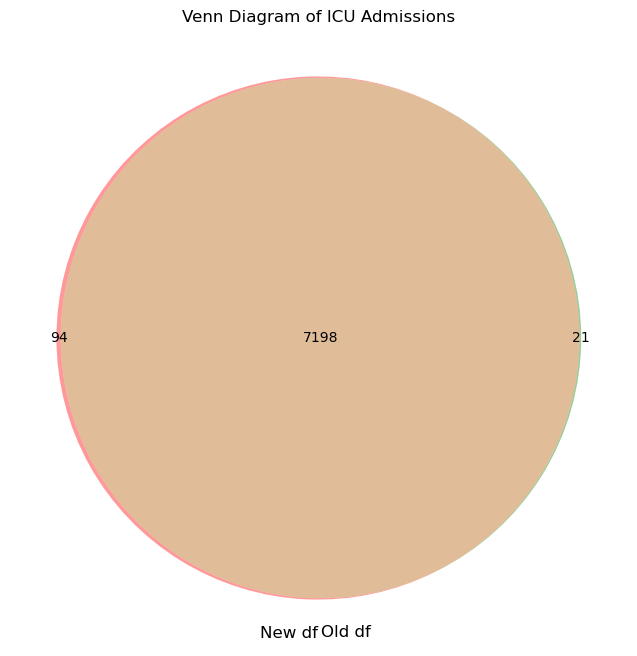

In [944]:
from matplotlib_venn import venn2

# Extract the unique IDs
set1 = set(DESC['VtfId_LopNr'])
set2 = set(OLD_DESC['VtfId_LopNr'])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2([set1, set2], ('New df', 'Old df'))
plt.title('Venn Diagram of ICU Admissions')
plt.show()

In [945]:
exclusive_to_new = set1 - set2
exclusive_to_old = set2 - set1

In [946]:
exclusive_new = DESC[DESC['VtfId_LopNr'].isin(exclusive_to_new)]

In [947]:
exclusive_new[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].head(40)

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
44,495.0,2016-12-08 05:30:00,2016-12-08 08:40:00,2016-12-08,2016-12-09,SU/IVA-MS,Sahlgrenska universitetssjukhuset,TUM,1,0,2016-12-08
129,1370.0,2014-10-03 13:15:00,2014-10-03 23:59:00,2014-10-03,2014-10-07,Karlstad-IVA,Sahlgrenska universitetssjukhuset,HC,1,0,2014-10-03
231,2285.0,2010-09-25 15:00:00,2010-09-25 18:30:00,2010-09-26,2010-10-15,IVA Kristianstad,Universitetssjukhuset i Lund,TBI,1,1,2010-09-26
321,3110.0,2013-07-18 10:45:00,2013-07-18 13:00:00,2013-07-18,2013-07-29,Helsingborg,Universitetssjukhuset i Lund,TBI,1,0,2013-07-18
336,3262.0,2020-07-21 13:00:00,2020-07-22 06:00:00,2020-07-21,2020-07-26,SU/IVA-INF,Sahlgrenska universitetssjukhuset,ABM,1,-1,2020-07-21
450,4264.0,2012-06-03 23:59:00,2012-06-04 02:40:00,2012-06-04,2012-06-20,Karlstad-IVA,Akademiska sjukhuset,ASAH,2,0,2012-06-04
524,4716.0,2018-07-05 10:26:00,2018-07-05 20:50:00,2018-07-06,2018-07-13,SÖS Med IVA,"Karolinska universitetssjukhuset, Solna",ICH,1,1,2018-07-06
647,5597.0,2016-05-27 15:30:00,2016-05-27 19:15:00,2016-05-27,2016-06-06,Karlstad-NOIVA,Akademiska sjukhuset,AIS,2,0,2016-05-27
688,5881.0,2020-03-18 04:15:00,2020-03-18 08:00:00,2020-03-18,2020-03-18,IVA Hudiksvall,Akademiska sjukhuset,AIS,2,0,2020-03-18
713,6109.0,2016-06-06 22:05:00,2016-06-07 01:00:00,2016-06-07,2016-06-17,Kungälv,Sahlgrenska universitetssjukhuset,TBI,1,0,2016-06-07


In [948]:
test = query + "SELECT * FROM PAR_HADM"
df = pd.read_sql(test, engine)

df['INDATUM'] = pd.to_datetime(df['INDATUM'], unit='D')
df['UTDATUM'] = pd.to_datetime(df['UTDATUM'], unit='D')
#df['AnkomstTidpunkt'] = pd.to_datetime(df['AnkomstTidpunkt'], unit='s').dt.normalize()
#df['UtskrTidPunkt'] = pd.to_datetime(df['UtskrTidPunkt'], unit='s').dt.normalize()
df.query("LopNr == 14801.0")[['INDATUM', 'UTDATUM', 'DIAGNOS', 'SJUKHUS', 'MVO']]

#	 2016-05-27	I638

,INDATUM,UTDATUM,DIAGNOS,SJUKHUS,MVO
83399,2016-09-06,2016-09-07,I620 Z720A,61404,101
83400,2016-09-07,2016-09-08,I620 Z921 Z867B,61010,301
83401,2016-09-07,2016-09-15,S065 I639,12001,331


In [949]:
test = query + "SELECT * FROM SIR_BASDATA"
df = pd.read_sql(test, engine)
df['AnkomstTidpunkt'] = pd.to_datetime(df['AnkomstTidpunkt'], unit='s')
df.query("LopNr == 14801.0")

,LopNr,VtfId_LopNr,Alder,Kon,AnkomstTidpunkt,AnkomstVag,Ankomstorsak,Akutinlaggning,Opererad,OpereradTid,...,AvdNamn,Sjukhus,Vardtyp,SjukhusTyp,Avdelningstyp,Moderklinik,AvlidenTid,Lengd,AnkIvaVikt,Solna
45028,14801.0,144094.0,62.0,M,2016-09-07 15:45:00,Operation (inkluderar interventionell radiolog...,None,Ja,Ja-akut,NaN,...,Gävle,Gävle sjukhus,IVA,Länssjukhus,IVA,Allmän kirurgi,NaN,NaN,NaN,0.0
45029,14801.0,144136.0,62.0,M,2016-09-07 11:00:00,Vårdavdelning,None,Ja,Nej,NaN,...,Bollnäs,Bollnäs Sjukhus Aleris,IVA,Länsdelssjukhu,IVA,Allmän internmedicin,NaN,NaN,NaN,0.0


In [950]:
query_DESC_PAR = query + "SELECT * FROM SUMMARY_TABLE"
DESC = pd.read_sql(query_DESC_PAR, engine)


DESC['par_adm_date'] = pd.to_datetime(DESC['par_adm_date'], unit='D')
DESC['par_dsc_date'] = pd.to_datetime(DESC['par_dsc_date'], unit='D')
#DESC['earliest_admit_date'] = pd.to_datetime(DESC['earliest_admit_date'], unit='D')
DESC['earliest_par_admit_date'] = pd.to_datetime(DESC['earliest_par_admit_date'], unit='D')

DESC['sir_adm_time'] = pd.to_datetime(DESC['sir_adm_time'], unit='s').dt.normalize()
DESC['sir_dsc_time'] = pd.to_datetime(DESC['sir_dsc_time'], unit='s').dt.normalize()
DESC['sir_adm_year'] = DESC['sir_adm_time'].dt.year

In [951]:
DESC[['LopNr', 'sir_adm_time', 'sir_dsc_time', 'par_adm_date', 'par_dsc_date', 'sir_icu_name', 'par_tertiary_center', 'DX_GROUP', 'rows_per_patient', 'par_admit_relative_sir_dsc', 'earliest_par_admit_date']].query("LopNr == 14801.0")

,LopNr,sir_adm_time,sir_dsc_time,par_adm_date,par_dsc_date,sir_icu_name,par_tertiary_center,DX_GROUP,rows_per_patient,par_admit_relative_sir_dsc,earliest_par_admit_date
1722,14801.0,2016-09-07,2016-09-07,2016-09-07,2016-09-15,Bollnäs,Akademiska sjukhuset,TBI,2,0,2016-09-07
1723,14801.0,2016-09-07,2016-09-08,2016-09-07,2016-09-15,Gävle,Akademiska sjukhuset,TBI,2,-1,2016-09-07


In [952]:
## you cant win can u....